In [17]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import re
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Import Data

In [18]:
adata = ad.read_h5ad('/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_zscore.h5ad')
adata.X = adata.layers['log1p_norm'].copy()

In [19]:
# replace linker-1 and linker-2 with just linker
adata.obs['ligand_call_oBC_CR'] = adata.obs['ligand_call_oBC_CR'].str.replace(
    r'linker-(1|2)', 'linker', regex=True)
print(adata.obs['ligand_call_oBC_CR'].unique())

['IL4_linker' 'IL4_IL12' 'IL12_IFNA' 'IL4_IFNA' 'IL12_linker' 'IL12_IL6'
 'IL2_TNF' 'IL21_linker' 'IFNA_linker' 'IL2_linker' 'IL2_IL6' 'IL4_IL6'
 'TNF_linker' 'IL2_IL12' 'IL2_IL4' 'IFNA_TNF' 'IL6_linker' 'IL4_IL21'
 'IL4_IL27' 'linker_linker' 'IL27_linker' 'IL27_TNF' 'IFNA_IL27'
 'IL6_IL21' 'IL2_IL27' 'IL4_TNF' 'IL6_TNF' 'IL2_IL21' 'IL6_IFNA'
 'IL6_IL27' 'IL2_IFNA' 'IL21_TNF' 'IFNA_IL21' 'IL21_IL27' 'IL12_TNF'
 'IL12_IL27' 'IL12_IL21']


In [20]:
# print number of cells per category
adata.obs['ligand_call_oBC_CR'].value_counts()

ligand_call_oBC_CR
TNF_linker       6643
IL4_linker       6527
IL2_linker       5895
IL27_linker      5523
IL6_linker       4026
IFNA_linker      3986
IL21_linker      3345
linker_linker    3111
IL4_TNF          2795
IL2_TNF          2769
IL27_TNF         2709
IL2_IL4          2619
IL12_linker      2617
IL4_IL27         2157
IL2_IL27         2149
IFNA_TNF         2064
IL6_TNF          1950
IL2_IL6          1900
IL2_IFNA         1834
IL4_IFNA         1827
IL4_IL6          1815
IFNA_IL27        1747
IL6_IL27         1711
IL21_TNF         1481
IL2_IL21         1443
IL12_IL27        1424
IL4_IL21         1413
IL12_TNF         1359
IFNA_IL21        1286
IL4_IL12         1269
IL6_IFNA         1175
IL12_IFNA        1101
IL21_IL27        1075
IL6_IL21          947
IL2_IL12          844
IL12_IL21         818
IL12_IL6          572
Name: count, dtype: int64

# Helper Functions

In [21]:
def anndata_X_to_df(adata):
    """
    Save the `.X` matrix of an AnnData object as a CSV file with cell barcodes and column names preserved.

    Parameters:
        adata: AnnData object
            The AnnData object containing the matrix to be saved.
        output_file: str
            The path to save the CSV file.
    """
    # Convert .X to a DataFrame
    df = pd.DataFrame(
        adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,  # Convert sparse matrix to dense if needed
        index=adata.obs.index,  # Use cell barcodes as row indices
        columns=adata.var.index  # Use feature names (e.g., gene names) as column names
    )
    
    # Save DataFrame to a CSV file
    return df

# Export Raw Counts and Obs

In [8]:
from scipy.sparse import csr_matrix
counts = csr_matrix(adata.layers['counts'])

In [10]:
from scipy.io import mmwrite
mmwrite("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_counts.mtx",counts)
adata.obs.to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_obs.csv")

In [17]:
genes = pd.DataFrame(index=adata.obs.index).to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_obs_cells.csv")
cells = pd.DataFrame(index=adata.var.index).to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_obs_genes.csv")

# Export HVG Counts and Obs

In [31]:
adataHV = adata[:,adata.var['highly_variable']].copy()

In [32]:
from scipy.sparse import csr_matrix
counts = csr_matrix(adataHV.layers['counts'])

In [33]:
from scipy.io import mmwrite
mmwrite("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_HVG_counts.mtx",counts)
adata.obs.to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_HVG_obs.csv")
pd.DataFrame(index=adataHV.obs.index).to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_HVG_obs_cells.csv")
pd.DataFrame(index=adataHV.var.index).to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_HVG_obs_genes.csv")

# Create Downsampled Data

In this data we have a lot of cells per ligand condition. However, I want to check how the DEGs and emergent interactions will change with fewer cell numbers. Thus, let's create a downsampled dataset to do DEG analysis on.

In [8]:
# Define the maximum number of cells per category
max_cells_per_category = 500

# Group cells by 'ligand_call_oBC_CR' and randomly sample up to `max_cells_per_category` per group
sampled_indices = (
    adata.obs.groupby(['ligand_call_oBC_CR'], group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), max_cells_per_category), random_state=42), include_groups=False)
    .index
)

# Subset the AnnData object using the sampled indices
downsampled_adata = adata[sampled_indices].copy()

# Check the result
print(f"Original AnnData: {adata.shape}")
print(f"Downsampled AnnData: {downsampled_adata.shape}")

Original AnnData: (87926, 10440)
Downsampled AnnData: (18500, 10440)


In [9]:
downsampled_adata.obs['ligand_call_oBC_CR'].value_counts()

ligand_call_oBC_CR
IFNA_IL21        500
IFNA_IL27        500
IFNA_TNF         500
IFNA_linker      500
IL12_IFNA        500
IL12_IL21        500
IL12_IL27        500
IL12_IL6         500
IL12_TNF         500
IL12_linker      500
IL21_IL27        500
IL21_TNF         500
IL21_linker      500
IL27_TNF         500
IL27_linker      500
IL2_IFNA         500
IL2_IL12         500
IL2_IL21         500
IL2_IL27         500
IL2_IL4          500
IL2_IL6          500
IL2_TNF          500
IL2_linker       500
IL4_IFNA         500
IL4_IL12         500
IL4_IL21         500
IL4_IL27         500
IL4_IL6          500
IL4_TNF          500
IL4_linker       500
IL6_IFNA         500
IL6_IL21         500
IL6_IL27         500
IL6_TNF          500
IL6_linker       500
TNF_linker       500
linker_linker    500
Name: count, dtype: int64

In [10]:
from scipy.sparse import csr_matrix
counts_ds = csr_matrix(downsampled_adata.layers['counts'])

In [16]:
from scipy.io import mmwrite
mmwrite("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_ds500_counts.mtx",counts_ds)
downsampled_adata.obs.to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_ds500_obs.csv")

In [17]:
genes = pd.DataFrame(index=downsampled_adata.obs.index).to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_ds500_obs_cells.csv")
cells = pd.DataFrame(index=downsampled_adata.var.index).to_csv("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_ds500_obs_genes.csv")

In [15]:
downsampled_adata.write(filename="/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_zscore_ds500.h5ad")

# Identify Robustly Expressed Genes

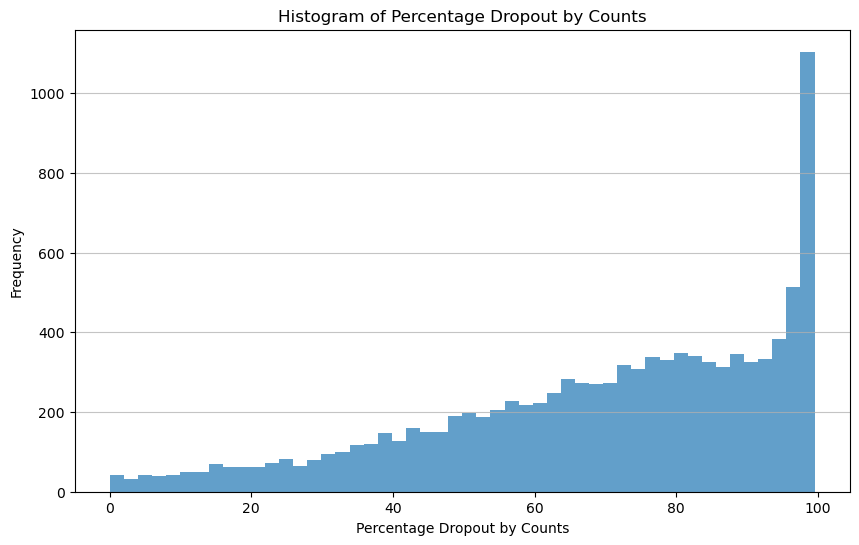

In [11]:
pct_dropout = adata.var['pct_dropout_by_counts']

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_dropout, bins=50, alpha=0.7)
plt.xlabel('Percentage Dropout by Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Dropout by Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [15]:
adata.var[adata.var.index.isin(['Tbx21','Rorc'])]

,gene_ids,feature_types,genome,pattern,read,sequence,target_gene_id,target_gene_name,mt,ribo,...,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mean,std,highly_variable,means,dispersions,dispersions_norm
Tbx21,ENSMUSG00000001444,Gene Expression,GRCm39,,,,,,False,False,...,0.019594,99.146618,5347.0,8.584478,0.005781,0.070956,True,0.015068,0.857248,3.970223
Rorc,ENSMUSG00000028150,Gene Expression,GRCm39,,,,,,False,False,...,0.021896,98.273252,5982.0,8.696677,0.012162,0.098941,True,0.019464,0.421826,1.628584


# Psuedobulk by mean average
Here, I will do pseudobulk by just averaging the log1p normalized counts between groups.

In [8]:
def mean_aggr_adata(adata, aggregate_columns=['ligand_call_oBC_CR']):
    """
    Aggregates an AnnData object by calculating mean expressions for groups defined by `aggregate_columns`.

    Parameters:
    -----------
    adata : AnnData
        Input AnnData object.
    aggregate_columns : list
        List of columns in `adata.obs` used to group and aggregate the data.

    Returns:
    --------
    AnnData
        A new AnnData object with aggregated (mean) expressions and updated `obs` and `var`.
    """
    # Create a DataFrame from the AnnData object
    df = pd.DataFrame(adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X,
                      index=adata.obs.index, 
                      columns=adata.var_names)
    
    # Add aggregate columns to the DataFrame
    for col in aggregate_columns:
        df[col] = adata.obs[col]
    
    # Group by the specified columns and compute mean expression
    mean_aggregated = df.groupby(aggregate_columns, observed=True).mean()
    
    # Extract the index of the grouped DataFrame (group identifiers)
    new_obs = mean_aggregated.index.to_frame(index=False)  # Convert MultiIndex to DataFrame
    
    # Convert the mean values back to a matrix
    new_X = mean_aggregated.values
    
    # Create a new AnnData object
    aggregated_adata = ad.AnnData(
        X=new_X,
        obs=new_obs,
        var=adata.var.copy()  # Retain the original gene information
    )
    
    return aggregated_adata

In [10]:
adataPB = mean_aggr_adata(adata, aggregate_columns=['ligand_call_oBC_CR','group_call_CR'])

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
adataPB

AnnData object with n_obs × n_vars = 95 × 10440
    obs: 'ligand_call_oBC_CR', 'group_call_CR'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [13]:
adataPB.write(filename="/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_log1p_mean_pseudobulk.h5ad")